# SWiFT Multifile
Demonstration of some of the mmctools functions and standards for postprocessing WRF-LES output <br>
Also includes examples of MMC spectra and correlation lengthscale functions.

#############################################################################

In [142]:
!pip3 freeze

argcomplete==1.7.0
asn1crypto==0.24.0
bcrypt==3.1.6
certifi==2018.10.15
cffi==1.9.1
chardet==3.0.4
conda==4.6.14
cookies==2.2.1
Cython==0.28.6
distro==1.5.0
fusepy==2.0.4
GF256==0.2.0
gitdb==0.6.4
GitPython==1.0.1
humanize==0.5.1
hvac==0.10.6
idna==2.10
iso8601==0.1.11
Jinja2==2.11.1
jsonschema==2.5.1
lark-parser==0.7.1
libgenders==1.2
MarkupSafe==0.23
mock==2.0.0
netifaces==0.10.9
numpy==1.19.5
packaging==16.8
pbr==4.2.0
ply==3.9
psutil==5.6.7
pycosat==0.6.3
pycparser==2.14
pycrypto==2.6.1
pyparsing==2.4.0
pyroute2==0.4.13
PySocks==1.6.8
PyYAML==3.13
requests==2.14.2
responses==0.5.1
rfc3986==1.3.0
rpm==4.11.3
ruamel.yaml==0.13.14
six==1.14.0
smmap==0.9.0
subrosa==0.1.0
templated-dictionary==1.1
urllib3==1.25.6
zxcvbn==4.4.28


## Preamble
Set file paths, enter physical constants, import modules, etc...

### Import modules

In [1]:
import glob
import os, re

# Well-known python modules (i.e, available through conda)

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import glob
import os
import sys

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Less well-known modules meant for Atmospheric sciences research 

import wrf #as wrf

module_path = os.path.join(os.environ['HOME'],'Codes/MMC/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)
import mmctools
#from mmctools.helper_functions import calc_spectra

### Physical constants and other parameters

In [3]:
g = 9.81 #[m/s/s], gravitational constant

### User-defined functions

In [4]:
sys.path.append('..')
from user_functions import postprocess_wrf_output, calc_mean_pert, calc_stresses, calc_tke
from user_functions import calc_ustar, calc_log_law

### File paths and file names

In [5]:
#Extracting folder names

base_sim_loc='/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/'
pdata_loc = '/g/g92/jha3/scratch/fromGiselle/Experiment'
fname_stem = 'wrfout_d01_0001-01-02_00*' # Starting from 00 hrs

DX=[]
DZ=[]
ALPHA=[]

for filename in os.listdir(base_sim_loc):
    if filename.startswith('DX'):
        dx = re.findall("DX_(\d+)_DZ", filename)
        DX.append(int(dx[0]))
        # initializing substrings
        sub1 = "DZ_"
        sub2 = "_ALPHA"
        idx1 = filename.index(sub1)
        idx2 = filename.index(sub2)
        dz = ''
        for idx in range(idx1 + len(sub1), idx2):
            dz = dz + filename[idx]
        DZ.append(dz)
        ALPHA.append(str(round(int(dx[0])/int(dz[0]),1)))
        


In [6]:
#Example of a path name ...
case_folder='DX_36_DZ_18.0_ALPHA_2.0'
#path + folder + '/' + fname_stem
os.path.join(base_sim_loc, case_folder, fname_stem)

'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00*'

In [7]:
#Example of searching on LC
!ls /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00*

/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:10:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:20:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:30:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:40:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:50:00


## Actual analysis begins (Load 4-D model output and Compute Spectra of each file)

In [8]:
###Simulation location
#Single file for testing
base_sim_loc = '/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1'
case_folder = 'DX_48_DZ_6.0_ALPHA_8.0'
simulation_loc = os.path.join(base_sim_loc, case_folder)

wrfoutfile_all = os.path.join(simulation_loc, fname_stem)
wrfoutfile_beg = os.path.join(simulation_loc, fname_stem[:-1] +':00:00')

if os.path.exists(wrfoutfile_beg):
    print('wrfout* files exist for the simulation case: {}'.format(simulation_loc))
    
wrfoutfilelist = glob.glob(wrfoutfile_all)
wrfoutfilelist.sort()
#wrfoutfilelist

wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_6.0_ALPHA_8.0


In [9]:
### Processed data location and files
process_data_3D = False # Flag to decide whether to process data or skip = False
update_data_3D = False   # Flage to decide whether to update already processed data
 
pdata_loc_3D = '/g/g92/jha3/scratch/fromGiselle/Experiment'
#pdata_loc_3D = '/p/lustre1/mgf/Wind_Energy/ProcessedDataForGroup'
pdata_loc_3D_upd = '/g/g92/jha3/scratch/fromGiselle/Experiment'
    
pdata_3D = os.path.join (pdata_loc_3D, 'pdata_3D_' + case_folder + '.nc')
pdata_3D_upd = os.path.join (pdata_loc_3D_upd, 'pdata_3D_' + case_folder + '.nc')

pdata_3D, pdata_3D_upd

('/g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_6.0_ALPHA_8.0.nc',
 '/g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_6.0_ALPHA_8.0.nc')

In [10]:
process_data_spectra = False # Flag to decide whether to process data or skip = False
update_data_spectra = False   # Flage to decide whether to update already processed data

pdata_loc_spectra = '/g/g92/jha3/scratch/fromGiselle/Experiment'
#pdata_loc_spectra = '/p/lustre1/mgf/Wind_Energy/ProcessedDataForGroup'
pdata_loc_spectra_upd = '/g/g92/jha3/scratch/fromGiselle/Experiment'


pdata_spectra = os.path.join (pdata_loc_spectra, 'pdata_spectra_' + case_folder + '.nc')
pdata_spectra_upd = os.path.join (pdata_loc_spectra_upd, 'pdata_spectra_' + case_folder + '.nc')

pdata_spectra, pdata_spectra_upd

('/g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_6.0_ALPHA_8.0.nc',
 '/g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_6.0_ALPHA_8.0.nc')

In [11]:
save_pdata = True
## 3D Data
if os.path.exists(pdata_3D):
    print ("Processed 3D data exists ... ")
    print ("Loading {}".format(pdata_3D))
    ds = xr.open_dataset(pdata_3D)
    if update_data_3D:
        print ("Updating the already processed 3D data ... ")
        ds = calc_stresses( ds, do_uw = True, do_vw = True, do_uv = True)
        ds = calc_ustar( ds )
        ds = calc_log_law (ds, kappa = 0.41, z0 = 0.2)
        if save_pdata:
            print("Saving the updated processed 3D data...")
            ds.to_netcdf(pdata_3D_upd)
            save_spectra_pdata = True
elif process_data_3D:
    print("Processed 3D data does not exist, reading from WRFOUT...")
    ds = xr.open_mfdataset( wrfoutfilelist, \
                           chunks = {'Time':10},
                           combine = 'nested',
                           concat_dim = 'Time'  )
    ds = postprocess_wrf_output( ds, z_max = 1100 ) #No subgrid stress/TKE components
    ds = calc_mean_pert( ds )
    ds = calc_stresses( ds )
    ds = calc_tke( ds )
    if save_pdata:
        print("Saving processed 3D data...")
        ds.to_netcdf(pdata_3D)
        save_spectra_pdata = True
else:
    print("Processed 3D data does not exist, Not processing either...")

Processed 3D data exists ... 
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_6.0_ALPHA_8.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [12]:
## Spectra
if os.path.exists(pdata_spectra):
    print("Processed spectra data exists...")
    print ("Loading {}".format(pdata_spectra))
    psd_ds = xr.open_dataset(pdata_spectra)
    if update_data_spectra:
        print ("Updating the already processed spectra data ... ")
        psd_ds = psd_ds
        if save_spectra_pdata:
            print("Saving the updated processed spectra data...")
            psd_ds.to_netcdf(pdata_spectra_upd)
elif process_data_spectra:
    from mmctools.helper_functions import calc_spectra
    print("Processed spectra data missing, calculating")
    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
    psd_list = []
    NT = len(ds.Time)
    for tt in range(0,NT):
        print(f"Time {tt} of {NT}")
        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                            var_oi=['U_p','W_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim='nx',\
                            level_dim='nz',
                            level = [5, 15, 25, 29]\
                             )

        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

    psd_ds = xr.concat( psd_list, "Time" )
    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

    psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 29]].values, dims = 'nz' )

    if save_spectra_pdata:
        print("Saving processed spectra data")
        psd_ds.to_netcdf( pdata_spectra )
else:
    print("Processed spectra data missing, Not calculating either...")

Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_6.0_ALPHA_8.0.nc


In [ ]:
#psd_ds

In [13]:
# Processing all files
base_sim_loc = '/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1'

pdata_loc_3D = '/g/g92/jha3/scratch/fromGiselle/Experiment'
#pdata_loc_3D = '/p/lustre1/mgf/Wind_Energy/ProcessedDataForGroup'
pdata_loc_3D_upd = '/g/g92/jha3/scratch/fromGiselle/Experiment'

pdata_loc_spectra = '/g/g92/jha3/scratch/fromGiselle/Experiment'
#pdata_loc_spectra = '/p/lustre1/mgf/Wind_Energy/ProcessedDataForGroup'
pdata_loc_spectra_upd = '/g/g92/jha3/scratch/fromGiselle/Experiment'

fname_stem = 'wrfout_d01_0001-01-02_00*'

num_dirs = 0
num_sim_total = 0 # Total number of simulation
num_sim_wrfout = 0 # Number of sim with wrfout data available
num_sim_pdata_3D = 0 # Number of sim for which processed data exist
num_sim_pdata_spectra = 0

# DX and DZ Corresponding to processed data
DX_PDATA = []
DZ_PDATA = []
for (dx, dz) in zip(DX, DZ):
    num_dirs +=1
    print('num_dirs: ', num_dirs)
    alpha = str(round(dx/float(dz),1))
    case_folder = f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
    simulation_loc = os.path.join(base_sim_loc, case_folder)

    if os.path.exists(simulation_loc):
        num_sim_total +=1
        print('num_sim_total: ', num_sim_total)
        print("Simulation data exists, working on folder:")
        print(simulation_loc)

        ### Processed data location and files
        pdata_3D = os.path.join (pdata_loc_3D, 'pdata_3D_' + case_folder + '.nc')
        pdata_3D_upd = os.path.join (pdata_loc_3D_upd, 'pdata_3D_' + case_folder + '.nc')
    
        pdata_spectra = os.path.join (pdata_loc_spectra, 'pdata_spectra_' + case_folder + '.nc')
        pdata_spectra_upd = os.path.join (pdata_loc_spectra_upd, 'pdata_spectra_' + case_folder + '.nc')

        wrfoutfile_all = os.path.join(simulation_loc, fname_stem)
        wrfoutfile_beg = os.path.join(simulation_loc, fname_stem[:-1] +':00:00')

        if os.path.exists(wrfoutfile_beg):
            num_sim_wrfout += 1
            print('num_sim_wrfout: ', num_sim_wrfout)
            print('wrfout* files exist for the simulation case: {}'.format(simulation_loc))
            print(wrfoutfile_beg)

            try:
                wrfoutfilelist = glob.glob(wrfoutfile_all)
                wrfoutfilelist.sort()
                # Use xarray.open_mfdataset. https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

                process_data_3D = False # Flag to decide whether to process data or skip = False
                update_data_3D = False   # Flage to decide whether to update already processed data
                
                process_data_spectra = False # Flag to decide whether to process data or skip = False
                update_data_spectra = False   # Flage to decide whether to update already processed data

                ## 3D Data
                save_pdata = True
                
                if os.path.exists(pdata_3D):
                    num_sim_pdata_3D += 1
                    print('num_sim_pdata_3D: ', num_sim_pdata_3D)
                    
                    print ("Processed 3D data exists ... ")
                    print ("Loading {}".format(pdata_3D))
                    ds = xr.open_dataset(pdata_3D)
                    
                    if update_data_3D:
                        print ("Updating the already processed 3D data ... ")
                        ds = calc_stresses( ds, do_uw = True, do_vw = True, do_uv = True)
                        ds = calc_ustar( ds )
                        ds = calc_log_law (ds, kappa = 0.41, z0 = 0.2)
                        if save_pdata:
                            print("Saving the updated processed 3D data...")
                            ds.to_netcdf(pdata_3D_upd)
                            save_spectra_pdata = True
                            
                    DX_PDATA.append(dx)
                    DZ_PDATA.append(dz)
                    
                elif process_data_3D:
                    print("Processed 3D data does not exist, reading from WRFOUT...")
                    ds = xr.open_mfdataset( wrfoutfilelist, \
                                           chunks = {'Time':10},
                                           combine = 'nested',
                                           concat_dim = 'Time'  )
                    ds = postprocess_wrf_output( ds, z_max = 1100 ) #No subgrid stress/TKE components
                    ds = calc_mean_pert( ds )
                    ds = calc_stresses( ds )
                    ds = calc_tke( ds )
                    if save_pdata:
                        print("Saving processed 3D data...")
                        ds.to_netcdf(pdata_3D)
                        save_spectra_pdata = True
                else:
                    print("Processed 3D data does not exist, Not processing either...")


                ## Spectra
                if os.path.exists(pdata_spectra):
                    num_sim_pdata_spectra += 1
                    print('num_sim_pdata_spectra: ', num_sim_pdata_spectra)
                    
                    print("Processed spectra data exists...")
                    print ("Loading {}".format(pdata_spectra))
                    psd_ds = xr.open_dataset(pdata_spectra)
                    
                    if update_data_spectra:
                        print ("Updating the already processed spectra data ... ")
                        psd_ds = psd_ds
                        if save_spectra_pdata:
                            print("Saving the updated processed spectra data...")
                            psd_ds.to_netcdf(pdata_spectra_upd)
                            
                elif process_data_spectra:
                    from mmctools.helper_functions import calc_spectra
                    
                    print("Processed spectra data missing, calculating")
                    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
                    psd_list = []
                    NT = len(ds.Time)
                    for tt in range(0,NT):
                        print(f"Time {tt} of {NT}")
                        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                                            var_oi=['U_p','W_p'],\
                                            spectra_dim='ny',\
                                            #average_dim='XTIME',\
                                            average_dim='nx',\
                                            level_dim='nz',
                                            level = [5, 15, 25, 29]\
                                             )

                        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

                    psd_ds = xr.concat( psd_list, "Time" )
                    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

                    psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 29]].values, dims = 'nz' )

                    if save_spectra_pdata:
                        print("Saving processed spectra data")
                        psd_ds.to_netcdf( pdata_spectra )
                else:
                    print("Processed spectra data missing, Not calculating either...")

            #f processing is not successful         
            except OSError:
                print('Passing, permission denied ...')
                pass
        else:
            print('wrfout* file does not exist for the simulation case')
            print(wrfoutfile_beg)

        print ('\n')

num_dirs:  1
num_sim_total:  1
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
num_sim_wrfout:  1
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  1
Processed 3D data exists ... 
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_4.0_ALPHA_3.0.nc
num_sim_pdata_spectra:  1
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_4.0_ALPHA_3.0.nc


num_dirs:  2
num_sim_total:  2
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.

num_sim_pdata_spectra:  11
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_24_DZ_6.0_ALPHA_4.0.nc


num_dirs:  16
num_sim_total:  14
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0
num_sim_wrfout:  13
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  12
Processed 3D data exists ... 
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_12.0_ALPHA_4.0.nc
num_sim_pdata_spectra:  12
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_12.0_ALPHA_4.0.nc


num_dirs:  17
num_sim_total:  15
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_

num_sim_pdata_spectra:  23
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_30_DZ_15.0_ALPHA_2.0.nc


num_dirs:  28
num_sim_total:  26
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0
num_sim_wrfout:  25
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  24
Processed 3D data exists ... 
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_18_DZ_9.0_ALPHA_2.0.nc
num_sim_pdata_spectra:  24
Processed spectra data exists...
Loading /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_18_DZ_9.0_ALPHA_2.0.nc


num_dirs:  29
num_sim_total:  27
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z

num_sim_wrfout:  38
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_6.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00
Processed 3D data does not exist, Not processing either...
Processed spectra data missing, Not calculating either...


num_dirs:  42
num_sim_total:  40
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5
num_sim_wrfout:  39
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_12.0_ALPHA_2.5/wrfout_d01_0001-01-02_00:00:00
Processed 3D data does not exist, Not processing either...
Processed spectra data missing, Not calculating either...




# Resample to hourly means
Requires playing with some dimension names surrounding Time

In [ ]:
#Single file only
'''
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
folder='DX_24_DZ_3.0_ALPHA_8.0'
pdata_3D = f'pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc'
pdata_spectra = f'pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc'

if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists",pdata_loc + pdata_3D)
                ds=xr.open_dataset( pdata_loc + pdata_3D )
                psd_ds=xr.open_dataset( pdata_loc + pdata_spectra )
                ds = ds.swap_dims({'Time': 'XTIME'})
                ds_1hr=ds.resample({'XTIME':'1H'}).mean()
                psd_ds= psd_ds.swap_dims({'Time': 'XTIME'})
                psd_ds_1hr = psd_ds.resample({'XTIME':'1H'}).mean()
'''

In [18]:
len(psd_ds_1hr)

30

In [14]:
# Processing all files, omitting the already processed ones
ds=[]
psd_ds=[]
ds_1hr=[]
psd_ds_1hr=[]
cases=[]

num_dirs = 0
num_sim_total = 0 # Total number of simulation
num_sim_wrfout = 0 # Number of sim with wrfout data available
num_sim_pdata_3D = 0 # Number of sim for which processed data exist
num_sim_pdata_spectra = 0
# DX and DZ Corresponding to processed data
DX_PDATA = []
DZ_PDATA = []
for (dx, dz) in zip(DX, DZ):
    num_dirs +=1
    print('num_dirs: ', num_dirs)
    alpha = str(round(dx/float(dz),1))
    case_folder = f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
    simulation_loc = os.path.join(base_sim_loc, case_folder)

    if os.path.exists(simulation_loc):
        num_sim_total +=1
        print('num_sim_total: ', num_sim_total)
        print("Simulation data exists, working on folder:")
        print(simulation_loc)

        ### Processed data location and files
        pdata_3D = os.path.join (pdata_loc_3D, 'pdata_3D_' + case_folder + '.nc')
        pdata_3D_upd = os.path.join (pdata_loc_3D_upd, 'pdata_3D_' + case_folder + '.nc')
    
        pdata_spectra = os.path.join (pdata_loc_spectra, 'pdata_spectra_' + case_folder + '.nc')
        pdata_spectra_upd = os.path.join (pdata_loc_spectra_upd, 'pdata_spectra_' + case_folder + '.nc')

        wrfoutfile_all = os.path.join(simulation_loc, fname_stem)
        wrfoutfile_beg = os.path.join(simulation_loc, fname_stem[:-1] +':00:00')

        if os.path.exists(wrfoutfile_beg):
            num_sim_wrfout += 1
            print('num_sim_wrfout: ', num_sim_wrfout)
            print('wrfout* files exist for the simulation case: {}'.format(simulation_loc))
            print(wrfoutfile_beg)
            
            ## 3D Data
            if os.path.exists(pdata_3D):
                num_sim_pdata_3D += 1
                print('num_sim_pdata_3D: ', num_sim_pdata_3D)

                print ("Processed 3D data exists... ")
                print ("Loading and appending {}".format(pdata_3D))
                ds.append(xr.open_dataset( pdata_3D ))

                ds[-1] = ds[-1].swap_dims({'Time': 'XTIME'})
                ds_1hr.append(ds[-1].resample({'XTIME':'1H'}).mean())

            else:
                print("Processed 3D data does not exist, Not processing either...")
                
            ## Spectra
            if os.path.exists(pdata_spectra):
                num_sim_pdata_spectra += 1
                print('num_sim_pdata_spectra: ', num_sim_pdata_spectra)
                
                print("Processed spectra data exists...")
                print ("Loading and appending {}".format(pdata_spectra))
                psd_ds.append(xr.open_dataset( pdata_spectra ))
                
                psd_ds[-1] = psd_ds[-1].swap_dims({'Time': 'XTIME'})
                psd_ds_1hr.append(psd_ds[-1].resample({'XTIME':'1H'}).mean())

            else:
                print("Processed spectra data missing, Not calculating either...")
                
            ### Cases
            cases.append(case_folder)
    
    
        else:
            print('wrfout* file does not exist for the simulation case')
            print(wrfoutfile_beg)
    
        print ('\n')

num_dirs:  1
num_sim_total:  1
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
num_sim_wrfout:  1
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  1
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_4.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  1
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_4.0_ALPHA_3.0.nc


num_dirs:  2
num_sim_total:  2
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5
wrfout* file does not exist for the simulation case
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_4.0_ALPHA_1.5/wrfout_d01_0001-01-02_00:00:00


num_dirs:  3
num_dirs:  4
num_sim_total:  3
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_4.5_ALPHA_4.0
num_sim_wrfout:  2
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_4.5_ALPHA_4.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_4.5_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  2
Processed 3D data exists... 
Loading and appending /g/

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  2
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_18_DZ_4.5_ALPHA_4.0.nc


num_dirs:  5
num_sim_total:  4
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0
num_sim_wrfout:  3
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  3
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_6.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  3
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_6.0_ALPHA_2.0.nc


num_dirs:  6
num_sim_total:  5
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_3.0_ALPHA_4.0
num_sim_wrfout:  4
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_3.0_ALPHA_4.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_3.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  4
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_3.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  4
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_3.0_ALPHA_4.0.nc


num_dirs:  7
num_sim_total:  6
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_6.0_ALPHA_5.0
num_sim_wrfout:  5
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_6.0_ALPHA_5.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_6.0_ALPHA_5.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  5
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_30_DZ_6.0_ALPHA_5.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  5
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_30_DZ_6.0_ALPHA_5.0.nc


num_dirs:  8
num_sim_total:  7
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_6.0_ALPHA_6.0
num_sim_wrfout:  6
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_6.0_ALPHA_6.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_6.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  6
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_36_DZ_6.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  6
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_36_DZ_6.0_ALPHA_6.0.nc


num_dirs:  9
num_sim_total:  8
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0
num_sim_wrfout:  7
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  7
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  7
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc


num_dirs:  10
num_sim_total:  9
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0
num_sim_wrfout:  8
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
Processed 3D data does not exist, Not processing either...
Processed spectra data missing, Not calculating either...


num_dirs:  11
num_sim_total:  10
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_12.0_ALPHA_1.5
num_sim_wrfout:  9
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_1

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  8
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_18_DZ_12.0_ALPHA_1.5.nc


num_dirs:  12
num_sim_total:  11
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_10.0_ALPHA_3.0
num_sim_wrfout:  10
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_10.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_10.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  9
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_30_DZ_10.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  9
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_30_DZ_10.0_ALPHA_3.0.nc


num_dirs:  13
num_sim_total:  12
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_12.0_ALPHA_3.0
num_sim_wrfout:  11
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_12.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_12.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  10
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_36_DZ_12.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  10
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_36_DZ_12.0_ALPHA_3.0.nc


num_dirs:  14
num_dirs:  15
num_sim_total:  13
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_6.0_ALPHA_4.0
num_sim_wrfout:  12
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_6.0_ALPHA_4.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_6.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  11
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_24_DZ_6.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  11
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_24_DZ_6.0_ALPHA_4.0.nc


num_dirs:  16
num_sim_total:  14
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0
num_sim_wrfout:  13
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_12.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  12
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_12.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  12
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_12.0_ALPHA_4.0.nc


num_dirs:  17
num_sim_total:  15
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_8.0_ALPHA_1.5
num_sim_wrfout:  14
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_8.0_ALPHA_1.5
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_8.0_ALPHA_1.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  13
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_8.0_ALPHA_1.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  13
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_8.0_ALPHA_1.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  18
num_sim_total:  16
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_8.0_ALPHA_4.5
num_sim_wrfout:  15
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_8.0_ALPHA_4.5
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_8.0_ALPHA_4.5/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  14
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_36_DZ_8.0_ALPHA_4.5.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  14
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_36_DZ_8.0_ALPHA_4.5.nc


num_dirs:  19
num_sim_total:  17
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_8.0_ALPHA_3.0
num_sim_wrfout:  16
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_8.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_8.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  15
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_24_DZ_8.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  15
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_24_DZ_8.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  20
num_sim_total:  18
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_9.0_ALPHA_4.0
num_sim_wrfout:  17
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_9.0_ALPHA_4.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_9.0_ALPHA_4.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  16
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_36_DZ_9.0_ALPHA_4.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  16
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_36_DZ_9.0_ALPHA_4.0.nc


num_dirs:  21
num_sim_total:  19
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_8.0_ALPHA_6.0
num_sim_wrfout:  18
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_8.0_ALPHA_6.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_8.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  17
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_8.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  17
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_8.0_ALPHA_6.0.nc


num_dirs:  22
num_sim_total:  20
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_18.0_ALPHA_1.0
num_sim_wrfout:  19
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_18.0_ALPHA_1.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_18.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  18
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_18_DZ_18.0_ALPHA_1.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  18
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_18_DZ_18.0_ALPHA_1.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/



num_dirs:  23
num_sim_total:  21
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_6.0_ALPHA_8.0
num_sim_wrfout:  20
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_6.0_ALPHA_8.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_6.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  19
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_6.0_ALPHA_8.0.nc
num_sim_pdata_spectra:  19
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_6.0_ALPHA_8.0.nc


num_dirs:  24
num_sim_total:  22
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_4.0_ALPHA_6.0
num_sim_wrfout:  21
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  20
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_24_DZ_4.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  25
num_sim_total:  23
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0
num_sim_wrfout:  22
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  21
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_24_DZ_12.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  21
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_24_DZ_12.0_ALPHA_2.0.nc


num_dirs:  26
num_sim_total:  24
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0
num_sim_wrfout:  23
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  22
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_36_DZ_18.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  22
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_36_DZ_18.0_ALPHA_2.0.nc


num_dirs:  27
num_sim_total:  25
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_15.0_ALPHA_2.0
num_sim_wrfout:  24
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_15.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_15.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  23
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_30_DZ_15.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  23
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_30_DZ_15.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  28
num_sim_total:  26
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0
num_sim_wrfout:  25
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_9.0_ALPHA_2.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  24
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_18_DZ_9.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  24
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_18_DZ_9.0_ALPHA_2.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  29
num_sim_total:  27
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_5.0_ALPHA_6.0
num_sim_wrfout:  26
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_5.0_ALPHA_6.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_30_DZ_5.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  25
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_30_DZ_5.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  25
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_30_DZ_5.0_ALPHA_6.0.nc


num_dirs:  30
num_sim_total:  28
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_6.0_ALPHA_3.0
num_sim_wrfout:  27
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_6.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_6.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  26
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_18_DZ_6.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  26
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_18_DZ_6.0_ALPHA_3.0.nc


num_dirs:  31
num_sim_total:  29
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_12.0_ALPHA_1.0
num_sim_wrfout:  28
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_12.0_ALPHA_1.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_12.0_ALPHA_1.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  27
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_12.0_ALPHA_1.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  27
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_12.0_ALPHA_1.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  32
num_sim_total:  30
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_7.2_ALPHA_5.0
num_sim_wrfout:  29
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_7.2_ALPHA_5.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_7.2_ALPHA_5.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  28
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_36_DZ_7.2_ALPHA_5.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


num_sim_pdata_spectra:  28
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_36_DZ_7.2_ALPHA_5.0.nc


num_dirs:  33
num_sim_total:  31
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_16.0_ALPHA_3.0
num_sim_wrfout:  30
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_16.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_48_DZ_16.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  29
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_48_DZ_16.0_ALPHA_3.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  29
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_48_DZ_16.0_ALPHA_3.0.nc


num_dirs:  34
num_sim_total:  32
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.0_ALPHA_6.0
num_sim_wrfout:  31
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.0_ALPHA_6.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_2.0_ALPHA_6.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  30
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_12_DZ_2.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/

num_sim_pdata_spectra:  30
Processed spectra data exists...
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_spectra_DX_12_DZ_2.0_ALPHA_6.0.nc


/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)




num_dirs:  35
num_sim_total:  33
Simulation data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_2.0_ALPHA_3.0
num_sim_wrfout:  32
wrfout* files exist for the simulation case: /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_2.0_ALPHA_3.0
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_2.0_ALPHA_3.0/wrfout_d01_0001-01-02_00:00:00
num_sim_pdata_3D:  31
Processed 3D data exists... 
Loading and appending /g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_6_DZ_2.0_ALPHA_3.0.nc


OSError: [Errno -101] NetCDF: HDF error: b'/g/g92/jha3/scratch/fromGiselle/Experiment/pdata_3D_DX_6_DZ_2.0_ALPHA_3.0.nc'

In [20]:
len(cases)

31

In [ ]:
pdata_3D = os.path.join (pdata_loc_3D, 'pdata_3D_' + case_folder + '.nc')

In [22]:
#Saving time average files
delta_t = '1H'
for i in range(len(ds_1hr)):
    pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + cases[i] + '.nc')
    pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + cases[i] + '.nc')
    
    if os.path.exists(pdata_3D_time_avg):
        print('3D time average file exists: {}'.format(pdata_3D_time_avg))
    else: 
        print('Saving 3D time average file: {}'.format(pdata_3D_time_avg))
        ds_1hr[i].to_netcdf(pdata_3D_time_avg)
        
    if os.path.exists(pdata_spectra_time_avg):
        print('Spectra time average file exists: {}'.format(pdata_spectra_time_avg))
    else: 
        print('Saving Spectra time average file: {}'.format(pdata_spectra_time_avg))
        psd_ds_1hr[i].to_netcdf(pdata_spectra_time_avg)

Saving 3D time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_3D_1H_DX_12_DZ_4.0_ALPHA_3.0.nc
Saving Spectra time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_spectra_1H_DX_12_DZ_4.0_ALPHA_3.0.nc
Saving 3D time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_3D_1H_DX_18_DZ_4.5_ALPHA_4.0.nc
Saving Spectra time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_spectra_1H_DX_18_DZ_4.5_ALPHA_4.0.nc
Saving 3D time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_3D_1H_DX_12_DZ_6.0_ALPHA_2.0.nc
Saving Spectra time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_spectra_1H_DX_12_DZ_6.0_ALPHA_2.0.nc
Saving 3D time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_3D_1H_DX_12_DZ_3.0_ALPHA_4.0.nc
Saving Spectra time average file: /g/g92/jha3/scratch/fromGiselle/Experiment/time_average_spectra_1H_DX_12_DZ_3.0_ALPHA_4.0.nc
Saving 3D time average f

In [24]:
#Saving data from all files in a sigle file (it doesn't work for reload, work with Will to solve the issue)  
#np.save(os.path.join( pdata_loc_3D, 'data_3D_1hr.npy'), ds_1hr)
#np.save(os.path.join( pdata_loc, 'data_spectra_1hr.npy'), psd_ds_1hr)    
#np.save(os.path.join( pdata_loc, 'pds_cases_names.npy'), cases) 

In [27]:
# This doesn't work
#ds_1hr_=np.load(pdata_loc + 'data_3D_1hr.npy',allow_pickle=True)
#psd_ds_1hr_=np.load(pdata_loc + 'data_spectra_1hr.npy',allow_pickle=True)   
#names_1hr_=np.load(pdata_loc + 'pds_cases_names.npy') 

In [29]:
ds_1hr=[]
psd_ds_1hr=[]

prefixed1 = [filename for filename in os.listdir(pdata_loc_3D) if filename.startswith("time_average_3D")]
prefixed2 = [filename for filename in os.listdir(pdata_loc_spectra) if filename.startswith("time_average_spectra")]

for i in range(len(prefixed1)):
    ds_1hr.append(xr.open_dataset(os.path.join(pdata_loc_3D, prefixed1[i])))
    psd_ds_1hr.append(xr.open_dataset(os.path.join(pdata_loc_spectra, prefixed2[i])))

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [33]:
#Number of hours considered, in our case just the first hour
NT_hr = len( ds_1hr[0].XTIME )

In [76]:
DX_PROC = []
DZ_PROC = []
ALPHA_PROC = []
for case in cases:
    DX = case.split('_')[1]
    DZ = case.split('_')[3]
    ALPHA = case.split('_')[5]
    DX_PROC.append(int(DX))
    DZ_PROC.append(float(DZ))
    ALPHA_PROC.append(ALPHA)

DX_unique = sorted(set(DX_PROC))
DZ_unique = sorted(set(DZ_PROC))
ALPHA_unique = set(ALPHA_PROC)

In [78]:
DX_unique

[6, 12, 18, 24, 30, 36, 48]

In [71]:
cases = cases[0:30]
sorted(cases)

['DX_12_DZ_12.0_ALPHA_1.0',
 'DX_12_DZ_3.0_ALPHA_4.0',
 'DX_12_DZ_4.0_ALPHA_3.0',
 'DX_12_DZ_6.0_ALPHA_2.0',
 'DX_12_DZ_8.0_ALPHA_1.5',
 'DX_18_DZ_12.0_ALPHA_1.5',
 'DX_18_DZ_18.0_ALPHA_1.0',
 'DX_18_DZ_4.5_ALPHA_4.0',
 'DX_18_DZ_6.0_ALPHA_3.0',
 'DX_18_DZ_9.0_ALPHA_2.0',
 'DX_24_DZ_12.0_ALPHA_2.0',
 'DX_24_DZ_3.0_ALPHA_8.0',
 'DX_24_DZ_4.0_ALPHA_6.0',
 'DX_24_DZ_6.0_ALPHA_4.0',
 'DX_24_DZ_8.0_ALPHA_3.0',
 'DX_30_DZ_10.0_ALPHA_3.0',
 'DX_30_DZ_15.0_ALPHA_2.0',
 'DX_30_DZ_5.0_ALPHA_6.0',
 'DX_30_DZ_6.0_ALPHA_5.0',
 'DX_36_DZ_12.0_ALPHA_3.0',
 'DX_36_DZ_18.0_ALPHA_2.0',
 'DX_36_DZ_6.0_ALPHA_6.0',
 'DX_36_DZ_7.2_ALPHA_5.0',
 'DX_36_DZ_8.0_ALPHA_4.5',
 'DX_36_DZ_9.0_ALPHA_4.0',
 'DX_48_DZ_12.0_ALPHA_4.0',
 'DX_48_DZ_16.0_ALPHA_3.0',
 'DX_48_DZ_6.0_ALPHA_8.0',
 'DX_48_DZ_8.0_ALPHA_6.0',
 'DX_6_DZ_3.0_ALPHA_2.0']

# Some plots

In [72]:
#Setting colormaps
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )
case_colormap = plt.cm.tab20c(np.linspace(0, 1, len(cases)) )

In [113]:
DZ_unique

[3.0, 4.0, 4.5, 5.0, 6.0, 7.2, 8.0, 9.0, 10.0, 12.0, 15.0, 16.0, 18.0]

### Vertical profiles

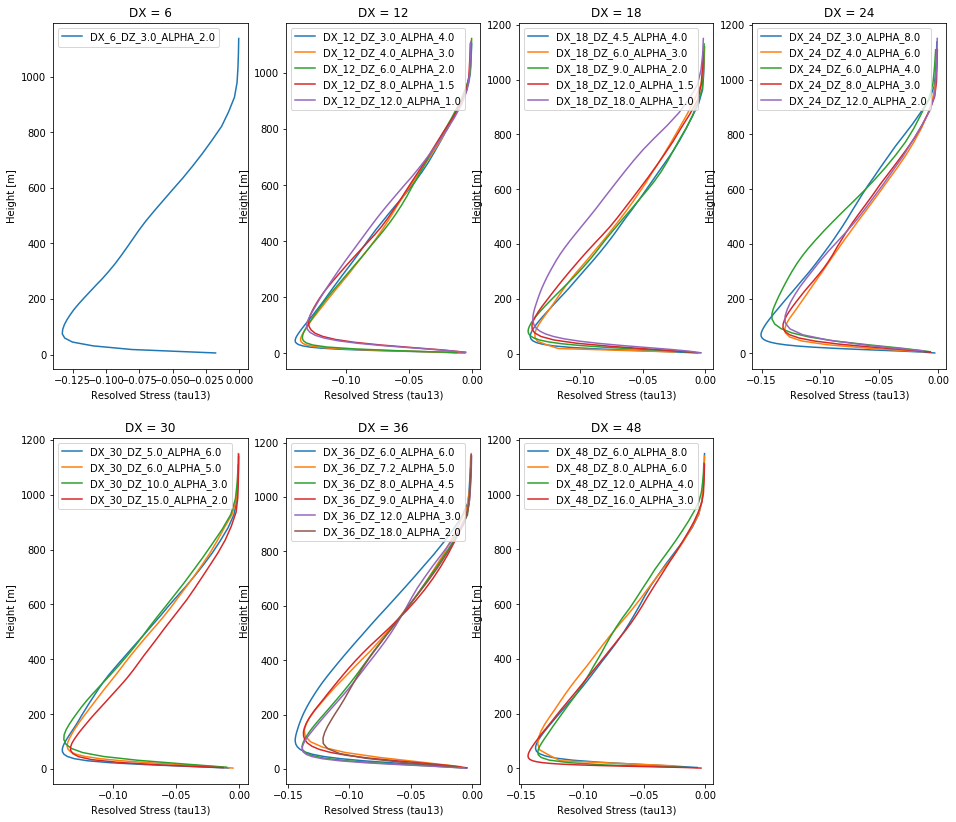

In [121]:
f, ax = plt.subplots( figsize = (16, 14) )
for dx_count, dx_unique in enumerate(DX_unique):
    plt.subplot(2,4, dx_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dz_unique in DZ_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).tau13, img.z , label= case_folder)
            
    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()

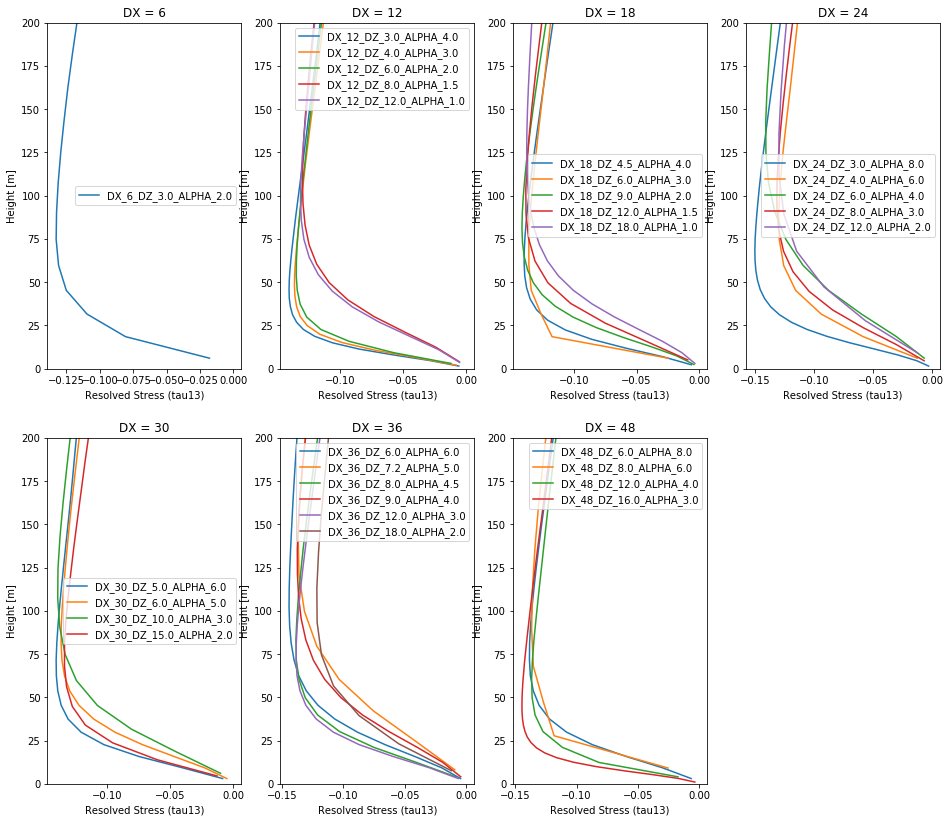

In [122]:
f, ax = plt.subplots( figsize = (16, 14) )
for dx_count, dx_unique in enumerate(DX_unique):
    plt.subplot(2,4, dx_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dz_unique in DZ_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).tau13, img.z , label= case_folder)
            
    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()
    plt.ylim([0,200])

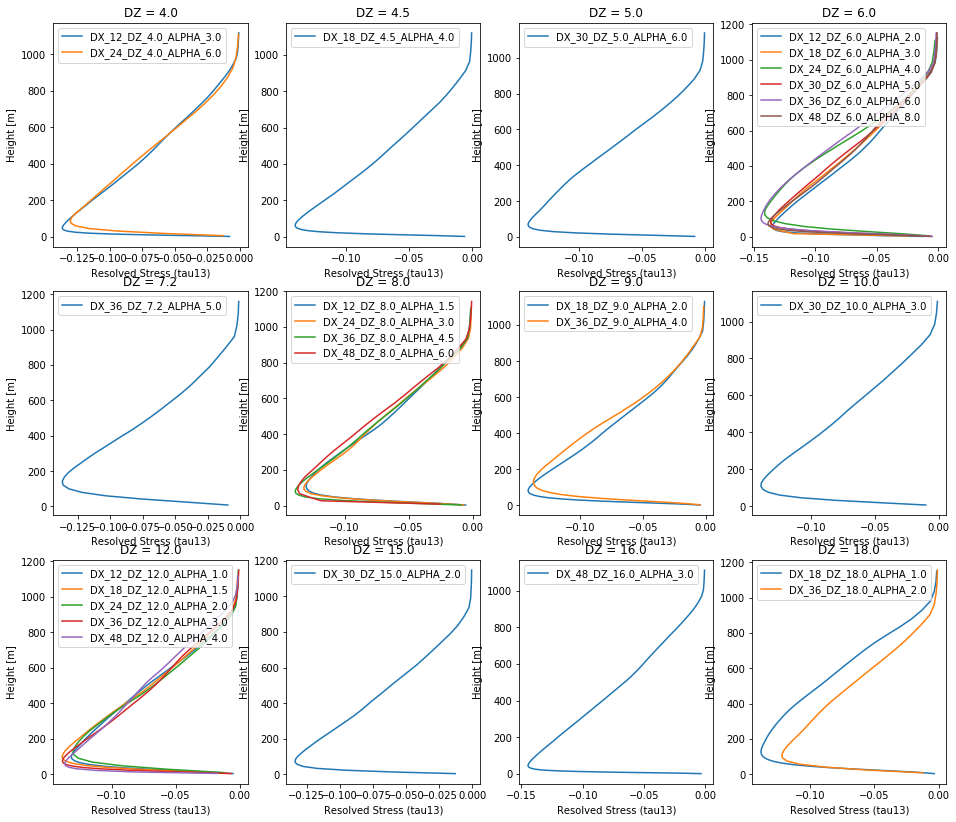

In [132]:
f, ax = plt.subplots( figsize = (16, 14) )
for dz_count, dz_unique in enumerate(DZ_unique[1:]):
    plt.subplot(3,4, dz_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dx_unique in DX_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).tau13, img.z , label= case_folder)
            
    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()

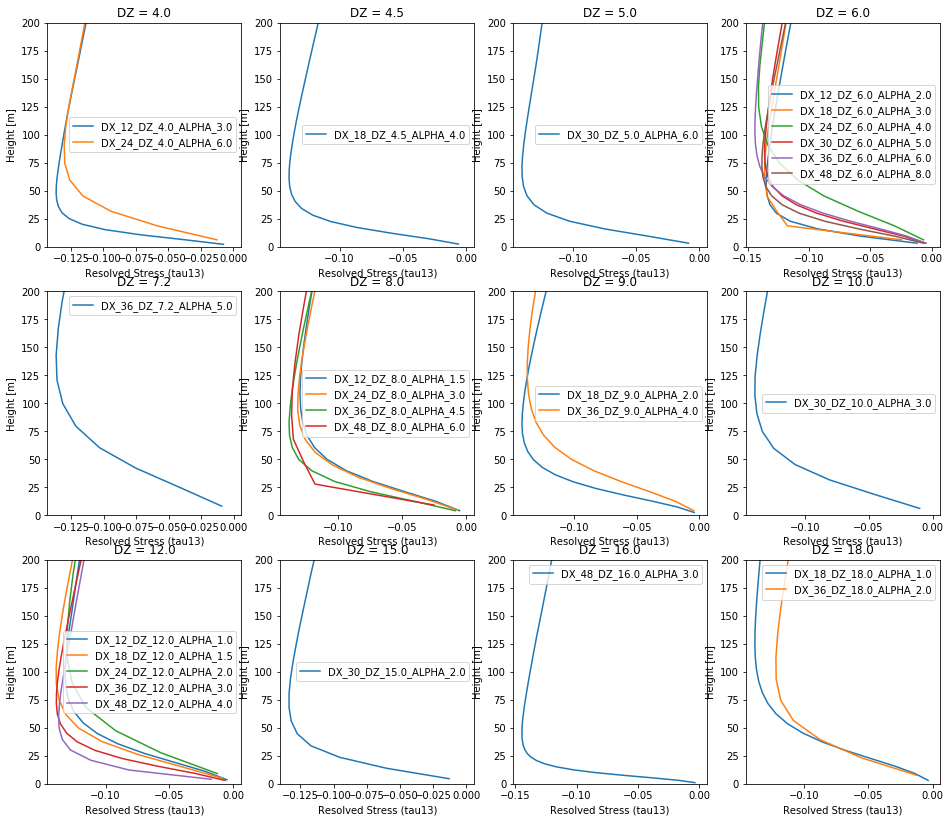

In [133]:
f, ax = plt.subplots( figsize = (16, 14) )
for dz_count, dz_unique in enumerate(DZ_unique[1:]):
    plt.subplot(3,4, dz_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dx_unique in DX_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).tau13, img.z , label= case_folder)
            
    plt.xlabel('Resolved Stress (tau13)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()
    plt.ylim([0,200])

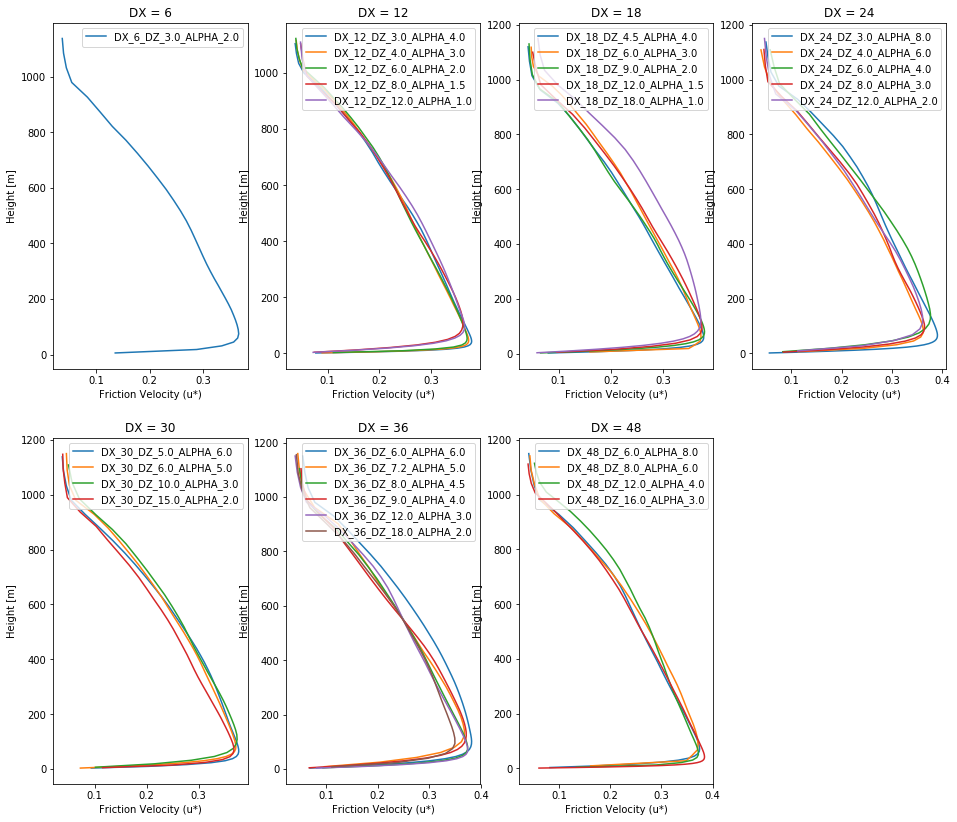

In [128]:
f, ax = plt.subplots( figsize = (16, 14) )
for dx_count, dx_unique in enumerate(DX_unique):
    plt.subplot(2,4, dx_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dz_unique in DZ_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).uStar, img.z , label= case_folder)
            
    plt.xlabel('Friction Velocity (u*)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()

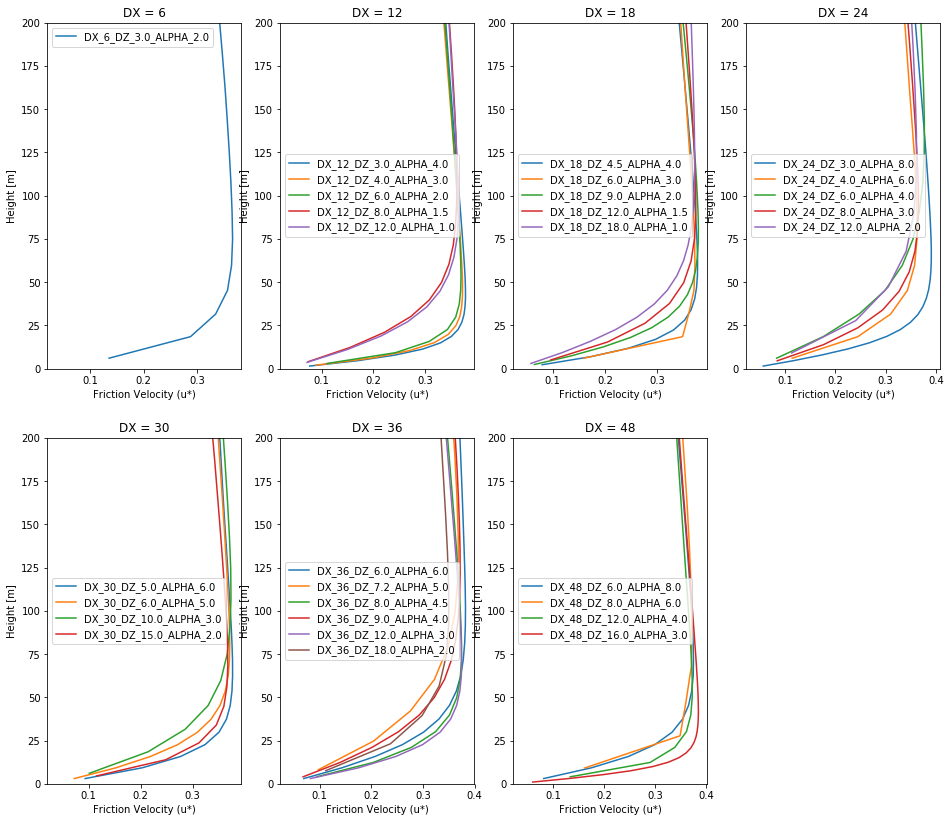

In [129]:
f, ax = plt.subplots( figsize = (16, 14) )
for dx_count, dx_unique in enumerate(DX_unique):
    plt.subplot(2,4, dx_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dz_unique in DZ_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).uStar, img.z , label= case_folder)
            
    plt.xlabel('Friction Velocity (u*)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()
    plt.ylim([0,200])

In [140]:
!pip3 freeze | grep xarray

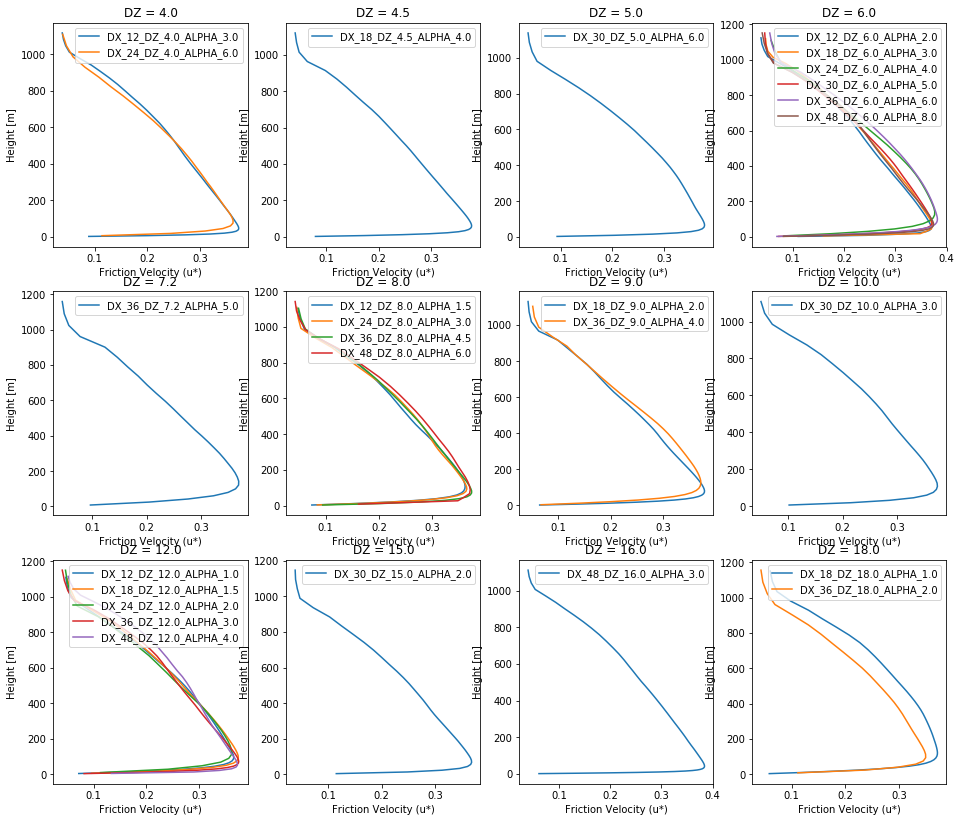

In [134]:
f, ax = plt.subplots( figsize = (16, 14) )
for dz_count, dz_unique in enumerate(DZ_unique[1:]):
    plt.subplot(3,4, dz_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dx_unique in DX_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).uStar, img.z , label= case_folder)
            
    plt.xlabel('Friction Velocity (u*)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()

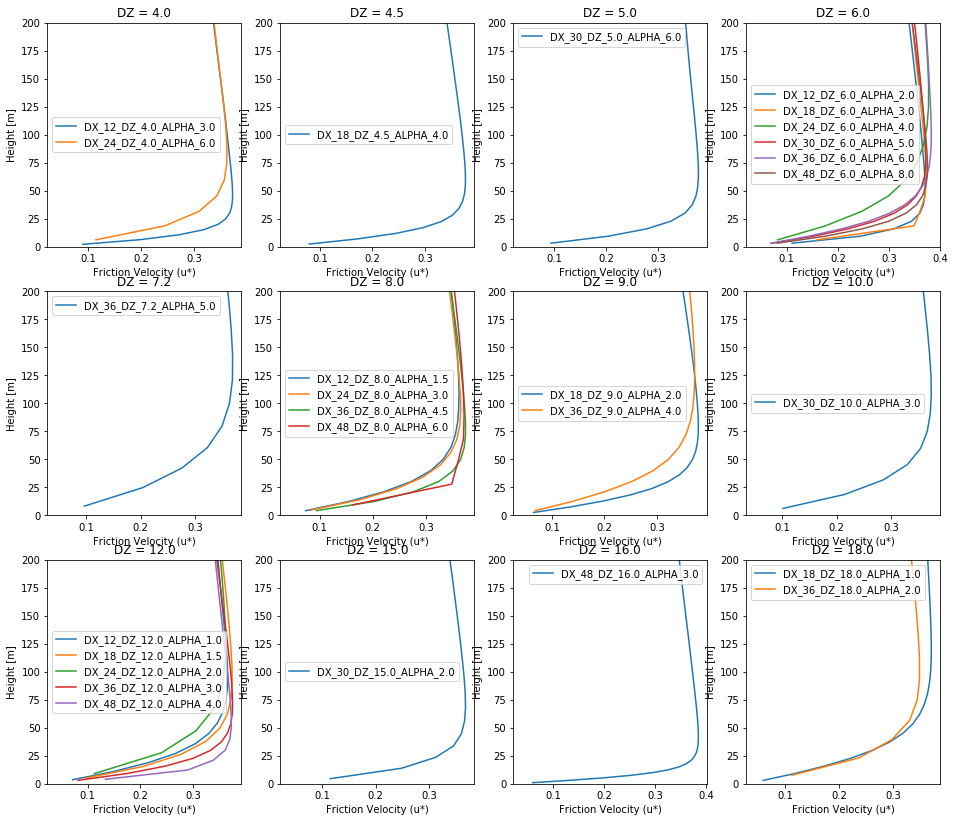

In [135]:
f, ax = plt.subplots( figsize = (16, 14) )
for dz_count, dz_unique in enumerate(DZ_unique[1:]):
    plt.subplot(3,4, dz_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dx_unique in DX_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).uStar, img.z , label= case_folder)
            
    plt.xlabel('Friction Velocity (u*)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()
    plt.ylim([0,200])

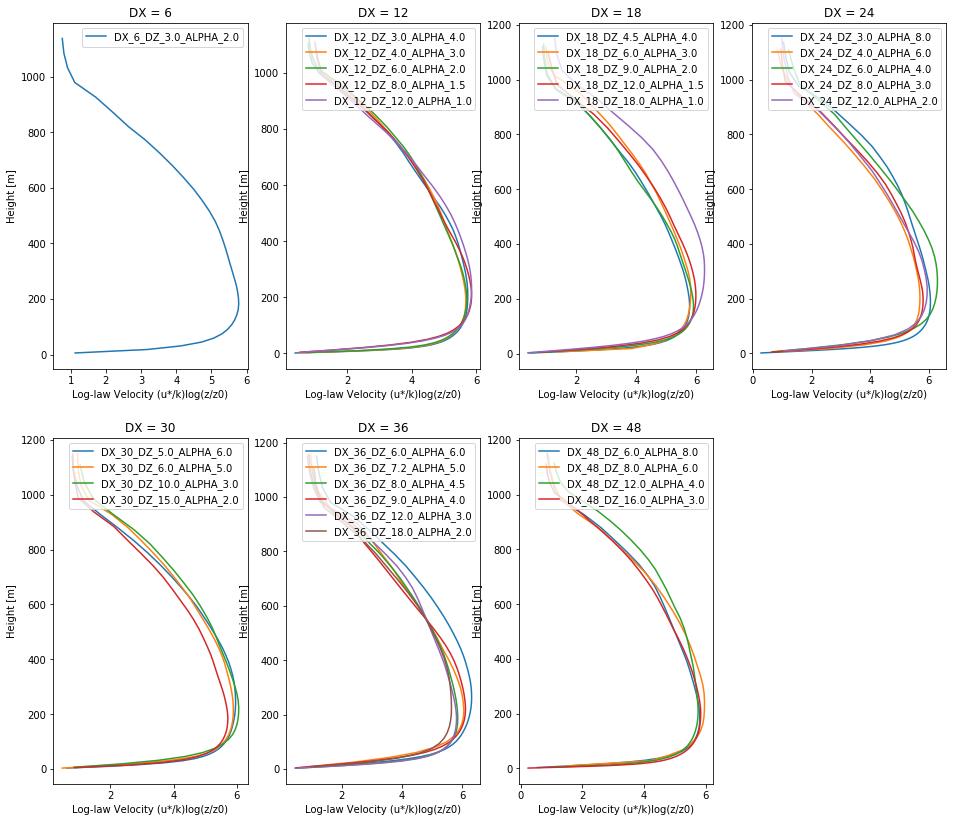

In [137]:
f, ax = plt.subplots( figsize = (16, 14) )
for dx_count, dx_unique in enumerate(DX_unique):
    plt.subplot(2,4, dx_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dz_unique in DZ_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).u_log_law, img.z , label= case_folder)
            
    plt.xlabel('Log-law Velocity (u*/k)log(z/z0)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()

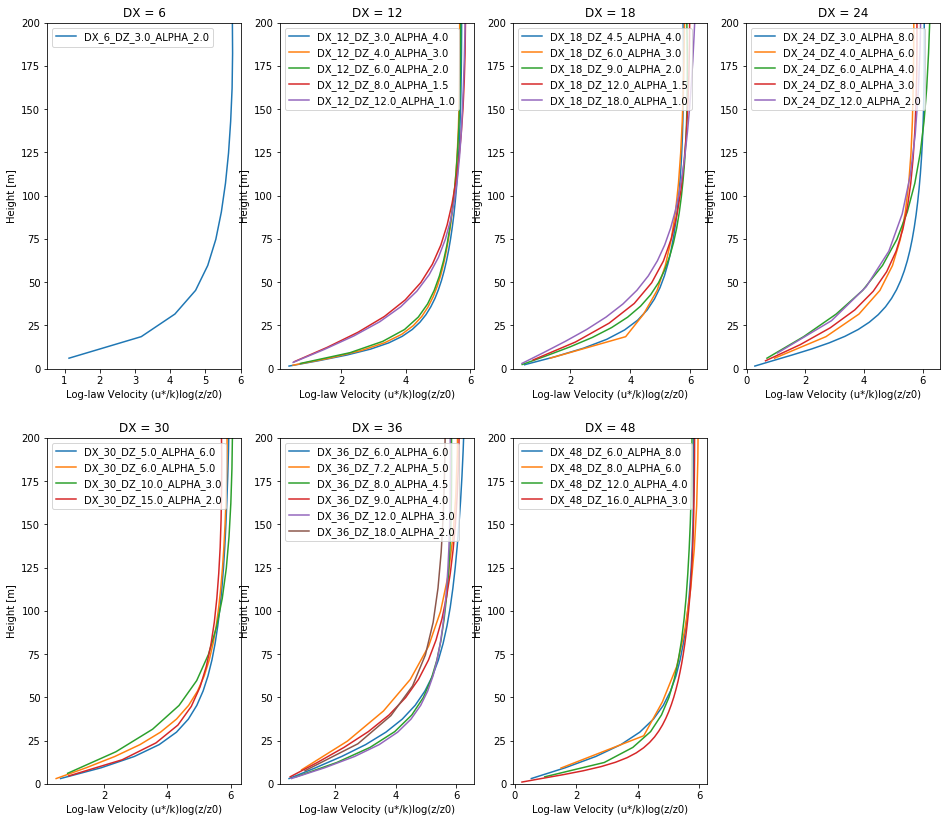

In [138]:
f, ax = plt.subplots( figsize = (16, 14) )
for dx_count, dx_unique in enumerate(DX_unique):
    plt.subplot(2,4, dx_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dz_unique in DZ_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).u_log_law, img.z , label= case_folder)
            
    plt.xlabel('Log-law Velocity (u*/k)log(z/z0)')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()
    plt.ylim([0,200])

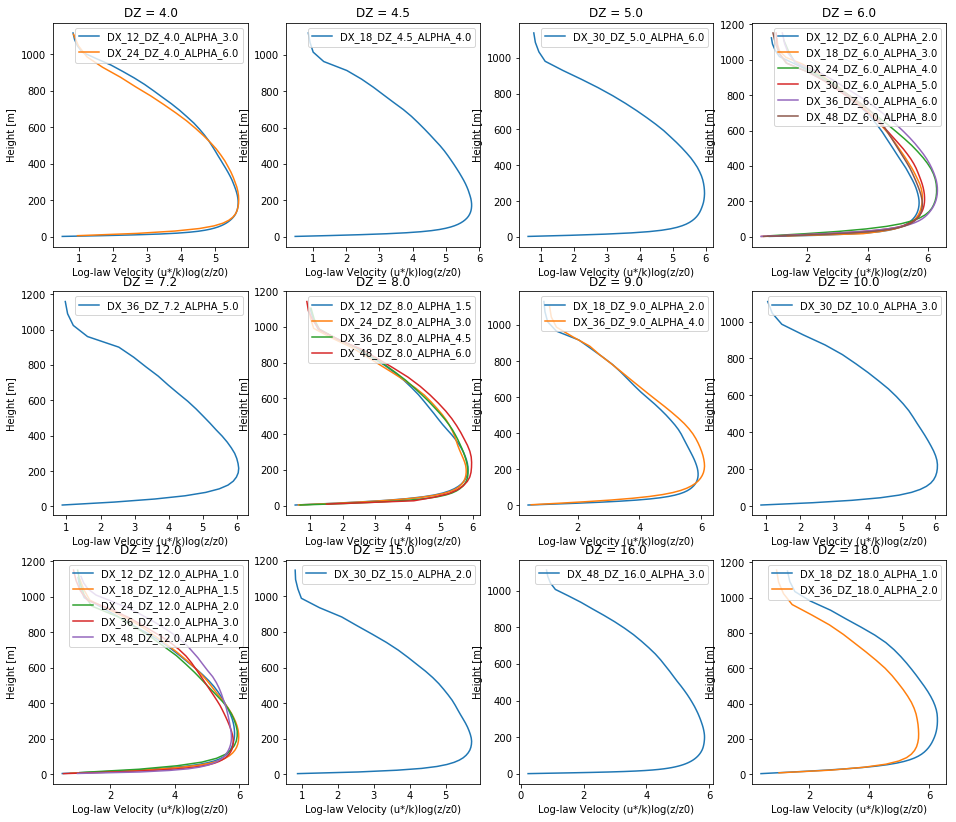

In [139]:
f, ax = plt.subplots( figsize = (16, 14) )
for dz_count, dz_unique in enumerate(DZ_unique[1:]):
    plt.subplot(3,4, dz_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dx_unique in DX_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).u_log_law, img.z , label= case_folder)
            
    plt.xlabel('Log-law Velocity (u*/k)log(z/z0)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()

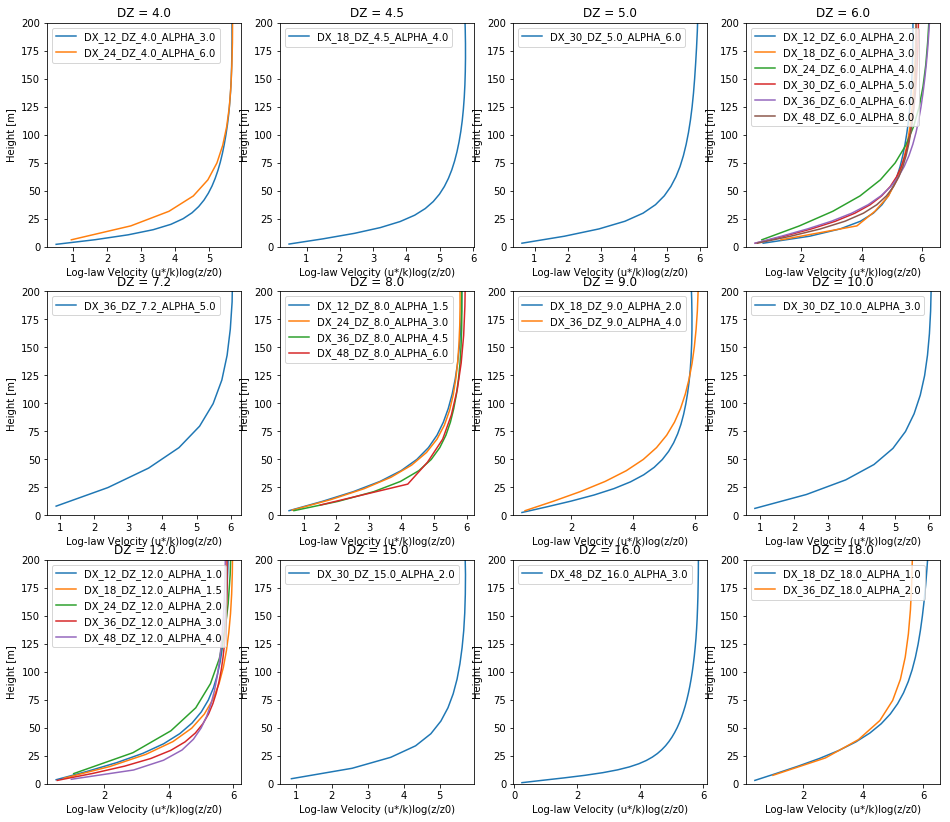

In [136]:
f, ax = plt.subplots( figsize = (16, 14) )
for dz_count, dz_unique in enumerate(DZ_unique[1:]):
    plt.subplot(3,4, dz_count+1)
    #plt.figure( figsize = (12, 10) )
    #print('dx_count : {}'.format(dx_count))
    
    for dx_unique in DX_unique:
        alpha = str(round(float(dx_unique)/float(dz_unique),1))
        case_folder = f'DX_{dx_unique}_DZ_{dz_unique}_ALPHA_{alpha}'
        
        pdata_3D_time_avg = os.path.join (pdata_loc_3D, 'time_average_3D_' + delta_t + '_' + case_folder + '.nc')
        #print('3D time average file: {}'.format(pdata_3D_time_avg))
        #pdata_spectra_time_avg = os.path.join (pdata_loc_spectra, 'time_average_spectra_' + delta_t + '_' + case_folder + '.nc')
        
        if os.path.exists(pdata_3D_time_avg):
            #print('3D time average file exists: {}'.format(pdata_3D_time_avg))
            img=xr.open_dataset(pdata_3D_time_avg)
            plt.plot(img.isel(XTIME = 0).u_log_law, img.z , label= case_folder)
            
    plt.xlabel('Log-law Velocity (u*/k)log(z/z0)')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()
    plt.ylim([0,200])

In [ ]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(cases)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

In [ ]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(cases)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

ax.set_ylim([0., 200])

In [ ]:
for dx_unique in DX_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DX == dx_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved TKE')
    plt.ylabel('Height [m]')
    plt.title('DX = {}'.format(dx_unique))
    plt.legend()
    
    plt.ylim([0.,200])

In [ ]:
for dz_unique in DZ_unique:
    plt.figure( figsize = (12, 10) )
    
    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        #print(DX, dx_unique)
        if DZ == dz_unique:   
            plt.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{cases[tt]}' )

    plt.xlabel('Resolved TKE')
    plt.ylabel('Height [m]')
    plt.title('DZ = {}'.format(dz_unique))
    plt.legend()
    
    plt.ylim([0.,200])

### Spectra

In [ ]:
#Spectra after one hour a function of cases
tind = 1
f, ax  = plt.subplots(figsize = ( 12, 6) )

z_spectra=0 #first level

for tt in range(0, len(cases)): 
    z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
    psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
    psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
    ax.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
            label = f'{cases[tt]}' )

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"U component, {tind} hours after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc = 'best')


In [ ]:
#Spectra after one hour a function of cases
for dx_unique in DX_unique:
    plt.figure( figsize = (12, 10) )
    tind = 1

    z_spectra=0 #first level

    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        if DX == dx_unique:
            z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
            psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
            psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
            plt.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
                    label = f'{cases[tt]}' )

    plt.ylabel('Power * frequency')    
    plt.xlabel('Frequency')

    plt.title(f"U component, {tind} hours after start, DX = {dx_unique}")

    plt.xscale('log')
    plt.yscale('log')

    plt.legend(loc = 'best')

In [ ]:
#Spectra after one hour a function of cases
for dz_unique in DZ_unique:
    plt.figure( figsize = (12, 10) )
    tind = 1

    z_spectra=0 #first level

    for tt in range(0, len(cases)):
        DX = cases[tt].split('_')[1]
        DZ = cases[tt].split('_')[3]
        
        if DZ == dz_unique:
            z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
            psd_ds_1hr[tt]['U_p_norm_power'] = psd_ds_1hr[tt].U_p * psd_ds_1hr[tt].frequency
            psd_ds_1hr[tt]['W_p_norm_power'] = psd_ds_1hr[tt].W_p * psd_ds_1hr[tt].frequency
            plt.plot( psd_ds_1hr[tt].frequency, psd_ds_1hr[tt].U_p_norm_power.isel(XTIME = 0, nz = 0),\
                    label = f'{cases[tt]}' )

    plt.ylabel('Power * frequency')    
    plt.xlabel('Frequency')

    plt.title(f"U component, {tind} hours after start, DZ = {dz_unique}")

    plt.xscale('log')
    plt.yscale('log')

    plt.legend(loc = 'best')